# Sc4 Project - Deep Learning

# 1. 주제 선정
### 👉🏻 바쁜 자영업자를 위한 광고 문안(a.k.a. 카피) 텍스트 생성기 만들기
- 음식 메뉴명 입력 시, 적합한 카피 생성

> 예시) 
- 맛있는 김치찌개
- 개운하고 깔끔한 김치찌개 / 쫄깃한 항정살을 듬뿍 넣은 김치찌개

### 👉🏻 광고 문안으로 베스트셀러 상품 예측하기

# 2. 데이터 선정
### - 마켓컬리 데이터를 이용


## 데이터 준비
- 제목 카피
- 컨텐츠 카피
- 각 카테고리별 인기순위 30 상품 라벨링

In [ ]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from string import punctuation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
data = pd.read_csv('kurly.csv', index_col=0).drop('index', axis=1)
print('전체 데이터 수 :{}'.format(len(data['title'])))
data.head()

전체 데이터 수 :15669


,title,contents
0,\n합리적 가격으로 만나는 국내산 애호박\n애호박\n,"어느 요리에든 어울리는, 만능 채소 일순위로 손꼽히는 애호박을 합리적인 가격으로 만..."
1,\n원하는 대로 섞어 만드는 하루치 건강\n무농약 간편 샐러드 6종\n,"짙은 녹색의 잎채소는 식이섬유부터 미네랄, 철분, 비타민, 엽산 등 각종 영양분이 ..."
2,\n무농약 콩으로 기른 장인의 나물\n[김구원선생] \n국내산 무농약 콩나물\n,"4대 째 두부 장인의 전통을 이어온 브랜드, 김구원선생의 콩나물을 소개할게요. 햇빛..."
3,\n청량하고 아삭한 채소\n다다기오이\n,"마디마다 열매가 다닥다닥 열린다 하여 붙여진 이름, 다다기오이. 꼭지로 갈수록 점차..."
4,"\n맛과 식감, 영양마저 뛰어난\n참타리 버섯\n","'참타리버섯' 하면 조금 낯설게 느껴질 수 있겠지만, 우리에게 친숙한 느타리 버섯의..."


In [ ]:
best = pd.read_csv('kurly_best.csv', index_col=0)
print('베스트 데이터 수 :{}'.format(len(best['title'])))
best.head()

베스트 데이터 수 :509


,title,contents,label
0,\n합리적 가격으로 만나는 국내산 애호박\n애호박\n,"어느 요리에든 어울리는, 만능 채소 일순위로 손꼽히는 애호박을 합리적인 가격으로 만...",1
1,\n원하는 대로 섞어 만드는 하루치 건강\n무농약 간편 샐러드 6종\n,"짙은 녹색의 잎채소는 식이섬유부터 미네랄, 철분, 비타민, 엽산 등 각종 영양분이 ...",1
2,\n무농약 콩으로 기른 장인의 나물\n[김구원선생] \n국내산 무농약 콩나물\n,"4대 째 두부 장인의 전통을 이어온 브랜드, 김구원선생의 콩나물을 소개할게요. 햇빛...",1
3,\n청량하고 아삭한 채소\n다다기오이\n,"마디마다 열매가 다닥다닥 열린다 하여 붙여진 이름, 다다기오이. 꼭지로 갈수록 점차...",1
4,"\n맛과 식감, 영양마저 뛰어난\n참타리 버섯\n","'참타리버섯' 하면 조금 낯설게 느껴질 수 있겠지만, 우리에게 친숙한 느타리 버섯의...",1


# 전처리
- '\n', '- 종' 등 텍스트 수정
- 브랜드명 삭제

In [ ]:
#best data + data
df = data.merge(best, on=['title', 'contents'], how='left')

#best data = 1, no best data = 0
df = df.fillna(0)

#중복값 제거
df = df.drop_duplicates()

df.tail()

,title,contents,label
15757,\n밋밋한 국물 맛이 확 깊어지는\n[선물세트]\n해통령 맛국물거리 세트\n,"가공하지 않은 순수한 원물이 그대로 쏙, 티백 안에 담겼어요. 천연 조미료 시장의 ...",0.0
15758,\n담백하고 고소한 프리미엄 피스타치오\n[원더풀] 피스타치오 무염&가염\n,피스타치오는 옅은 갈색의 껍질을 갈라 먹는 재미가 쏠쏠한 견과류예요. 짙은 초록빛의...,0.0
15759,\n진한 고소함을 품은 프리미엄 아몬드\n[원더풀] 아몬드 무염&가염\n,우리에게 익숙한 아몬드는 바삭하고 오독한 식감과 고소함이 번져오는 맛으로 오감을 만...,0.0
15760,\n새콤달콤 과일의 풍미가 가득 담긴\n[갈바니나] 유기농 과일 탄산수 6종 (박스)\n,"이탈리아를 대표하는 미네랄 워터 브랜드, 갈바니나의 유기농 과일 탄산수예요. 한 입...",0.0
15761,\n근사한 브런치도 간편하게\n[정미경키친]\n달걀 샌드위치 스프레드\n,"바쁜 아침 시간, 식사 준비는 정말 힘에 부치지요. 하지만 정미경키친의 샌드위치 스...",0.0


In [ ]:
#\n 수정
titles = df['title']
titles_=titles.str.replace('\n', ' ')
df['title']=titles_
df.head()

,title,contents,label
0,합리적 가격으로 만나는 국내산 애호박 애호박,"어느 요리에든 어울리는, 만능 채소 일순위로 손꼽히는 애호박을 합리적인 가격으로 만...",1.0
1,원하는 대로 섞어 만드는 하루치 건강 무농약 간편 샐러드 6종,"짙은 녹색의 잎채소는 식이섬유부터 미네랄, 철분, 비타민, 엽산 등 각종 영양분이 ...",1.0
3,무농약 콩으로 기른 장인의 나물 [김구원선생] 국내산 무농약 콩나물,"4대 째 두부 장인의 전통을 이어온 브랜드, 김구원선생의 콩나물을 소개할게요. 햇빛...",1.0
4,청량하고 아삭한 채소 다다기오이,"마디마다 열매가 다닥다닥 열린다 하여 붙여진 이름, 다다기오이. 꼭지로 갈수록 점차...",1.0
5,"맛과 식감, 영양마저 뛰어난 참타리 버섯","'참타리버섯' 하면 조금 낯설게 느껴질 수 있겠지만, 우리에게 친숙한 느타리 버섯의...",1.0


In [ ]:
titles = []
titles.extend(list(df.title.values))
contents = []
contents.extend(list(df.contents.values))

In [ ]:
#브랜드명 삭제

for i in range(len(titles)):
  titles[i]=re.sub(r'\[[^)]*\]', '', titles[i])

In [ ]:
#n종 삭제
for j in range(len(titles)):
  for i in range(1,10):
    try:
      titles[j]=titles[j].replace(str(i)+'종','')
    except:
      pass

df['title'] = titles
df.tail()

,title,contents,label
15757,밋밋한 국물 맛이 확 깊어지는 해통령 맛국물거리 세트,"가공하지 않은 순수한 원물이 그대로 쏙, 티백 안에 담겼어요. 천연 조미료 시장의 ...",0.0
15758,담백하고 고소한 프리미엄 피스타치오 피스타치오 무염&가염,피스타치오는 옅은 갈색의 껍질을 갈라 먹는 재미가 쏠쏠한 견과류예요. 짙은 초록빛의...,0.0
15759,진한 고소함을 품은 프리미엄 아몬드 아몬드 무염&가염,우리에게 익숙한 아몬드는 바삭하고 오독한 식감과 고소함이 번져오는 맛으로 오감을 만...,0.0
15760,새콤달콤 과일의 풍미가 가득 담긴 유기농 과일 탄산수 (박스),"이탈리아를 대표하는 미네랄 워터 브랜드, 갈바니나의 유기농 과일 탄산수예요. 한 입...",0.0
15761,근사한 브런치도 간편하게 달걀 샌드위치 스프레드,"바쁜 아침 시간, 식사 준비는 정말 힘에 부치지요. 하지만 정미경키친의 샌드위치 스...",0.0


# EDA

## 단어 빈도 기준

#### 한글 시각화 폰트 설치

In [ ]:
!apt-get install fonts-nanum*
!apt-get install fontconfig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20170925-1).
fonts-nanum-coding is already the newest version (2.5-1).
fonts-nanum-eco is already the newest version (1.000-6).
fonts-nanum-extra is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fontconfig is already the newest version (2.12.6-0ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

NanumGothic Eco


### 형태소 분석 _ 명사, 동사, 형용사

In [ ]:
!pip install konlpy

In [ ]:
from konlpy.tag import Okt  
okt=Okt()

In [ ]:
# 불용어, 특수문자 제거 후 토큰화 하는 함수
def text_stem(text,stopwords, okt):
    
    txt = re.sub('[^가-힣a-z]', ' ', text)
    token = okt.pos(txt, stem=True)
    clean_words=[]
    for word in token:
      if word[0] not in stopwords and word[1] in ['Noun', 'Verb', 'Adjective'] and word[0] not in clean_words:
        clean_words.append(word[0])
        
    return clean_words

In [ ]:
# '한국어불용어100'으로 불용어 지정
stop = pd.read_csv('stopwords.txt', sep='\t', header=None)
stopwords = stop[0].to_list()
print(stopwords)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓']


In [ ]:
text_stem(titles[0], stopwords, okt)

['합리', '가격', '만나다', '국내', '산', '애호박']

In [ ]:
# title과 contents에 적용
title_token = []
for i in range(len(titles)):
  title_token.append(text_stem(titles[i],stopwords,okt))

contents_token = []
for i in range(len(contents)):
  contents_token.append(text_stem(contents[i],stopwords,okt))

In [ ]:
print(titles[0])
print(title_token[0],'\n')
print(contents[0])
print(contents_token[0])

 합리적 가격으로 만나는 국내산 애호박 애호박 
['합리', '가격', '만나다', '국내', '산', '애호박'] 

어느 요리에든 어울리는, 만능 채소 일순위로 손꼽히는 애호박을 합리적인 가격으로 만나보세요. 전국의 품질 좋은 농산물이 모여드는 가락시장에서 공수했답니다. 맛 좋고 품질 뛰어난 국내산 애호박이죠. 선명한 연둣빛 과피 속으로는 부드러운 식감과 본연의 단 내음이 신선하게 살아 있어요. 식이섬유, 칼륨, 비타민 등 각종 영양이 풍부한 것은 물론이고요. 맛과 영양을 보장하는 애호박으로 애호박전, 애호박 찌개, 애호박 무침, 애호박 수프 등의 요리를 다채롭게 즐겨보세요. 1개입씩 준비했으니, 그때그때 원하는 만큼씩 담아 가세요.
['요리', '어울리다', '만능', '채소', '위로', '손꼽다', '애호박', '합리', '가격', '만나다', '보다', '전국', '품질', '좋다', '농산물', '모여들다', '가락시장', '공수', '하다', '맛', '뛰어나다', '국내', '산', '선명하다', '연둣빛', '과피', '부드럽다', '식감', '본연', '단', '음', '신선하다', '있다', '식이섬유', '칼륨', '비타민', '각종', '영양', '풍부하다', '고요', '보장', '찌개', '무치다', '수프', '다채롭', '즐기다', '개입', '준비', '그때', '원하다', '담다', '가세']


In [ ]:
df['stem_title'] = title_token
df['stem_contents'] = contents_token
df.head()

,title,contents,label,stem_title,stem_contents
0,합리적 가격으로 만나는 국내산 애호박 애호박,"어느 요리에든 어울리는, 만능 채소 일순위로 손꼽히는 애호박을 합리적인 가격으로 만...",1.0,"[합리, 가격, 만나다, 국내, 산, 애호박]","[요리, 어울리다, 만능, 채소, 위로, 손꼽다, 애호박, 합리, 가격, 만나다, ..."
1,원하는 대로 섞어 만드는 하루치 건강 무농약 간편 샐러드,"짙은 녹색의 잎채소는 식이섬유부터 미네랄, 철분, 비타민, 엽산 등 각종 영양분이 ...",1.0,"[원하다, 대로, 섞다, 만들다, 하루, 치, 건강, 무, 농약, 간편, 샐러드]","[짙다, 녹색, 잎채소, 식이섬유, 미네랄, 철분, 비타민, 엽산, 각종, 영양분,..."
3,무농약 콩으로 기른 장인의 나물 국내산 무농약 콩나물,"4대 째 두부 장인의 전통을 이어온 브랜드, 김구원선생의 콩나물을 소개할게요. 햇빛...",1.0,"[무, 농약, 콩, 기르다, 장인, 나물, 국내, 산, 콩나물]","[대다, 째다, 두부, 장인, 전통, 이다, 온, 브랜드, 김구, 선생, 콩나물, ..."
4,청량하고 아삭한 채소 다다기오이,"마디마다 열매가 다닥다닥 열린다 하여 붙여진 이름, 다다기오이. 꼭지로 갈수록 점차...",1.0,"[청량하다, 삭, 채소, 다다, 오이]","[마디, 열매, 린다, 하다, 붙이다, 이름, 다다, 오이, 꼭지, 갈수록, 점차,..."
5,"맛과 식감, 영양마저 뛰어난 참타리 버섯","'참타리버섯' 하면 조금 낯설게 느껴질 수 있겠지만, 우리에게 친숙한 느타리 버섯의...",1.0,"[맛, 식감, 영양, 뛰어나다, 차다, 타다, 버섯]","[차다, 타다, 버섯, 하다, 조금, 낯설다, 느껴지다, 있다, 친숙하다, 느타리,..."


#### 단어 카운트

In [ ]:
def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [ ]:
# title 카운트
title_wc = word_count(df['stem_title'])
title_wc.head(15)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
39,하다,1598,1598,1.0,0.017446,0.017446,0.128292
55,즐기다,965,965,2.0,0.010536,0.027982,0.077473
27,맛,888,888,3.0,0.009695,0.037677,0.071291
148,부드럽다,641,641,4.0,0.006998,0.044675,0.051461
248,위,589,589,5.0,0.006430,0.051105,0.047286
40,고소하다,560,560,6.0,0.006114,0.057219,0.044958
95,달콤하다,521,521,7.0,0.005688,0.062907,0.041827
107,간편하다,507,507,8.0,0.005535,0.068443,0.040703
68,향,487,487,9.0,0.005317,0.073759,0.039098
186,밉다,466,466,10.0,0.005088,0.078847,0.037412


In [ ]:
# contents 카운트
contents_wc = word_count(df['stem_contents'])
contents_wc.head(15)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
31,하다,12063,12063,1.0,0.017811,0.017811,0.968449
2,있다,9365,9365,2.0,0.013827,0.031638,0.751846
16,보다,7864,7864,3.0,0.011611,0.043248,0.631342
36,좋다,4898,4898,4.0,0.007232,0.050480,0.393224
85,거,4871,4871,5.0,0.007192,0.057672,0.391057
42,맛,4719,4719,6.0,0.006967,0.064639,0.378854
0,즐기다,4715,4715,7.0,0.006961,0.071601,0.378532
176,만들다,4389,4389,8.0,0.006480,0.078081,0.352360
69,않다,4014,4014,9.0,0.005926,0.084007,0.322254
204,사용,3954,3954,10.0,0.005838,0.089845,0.317437


In [ ]:
!pip install squarify

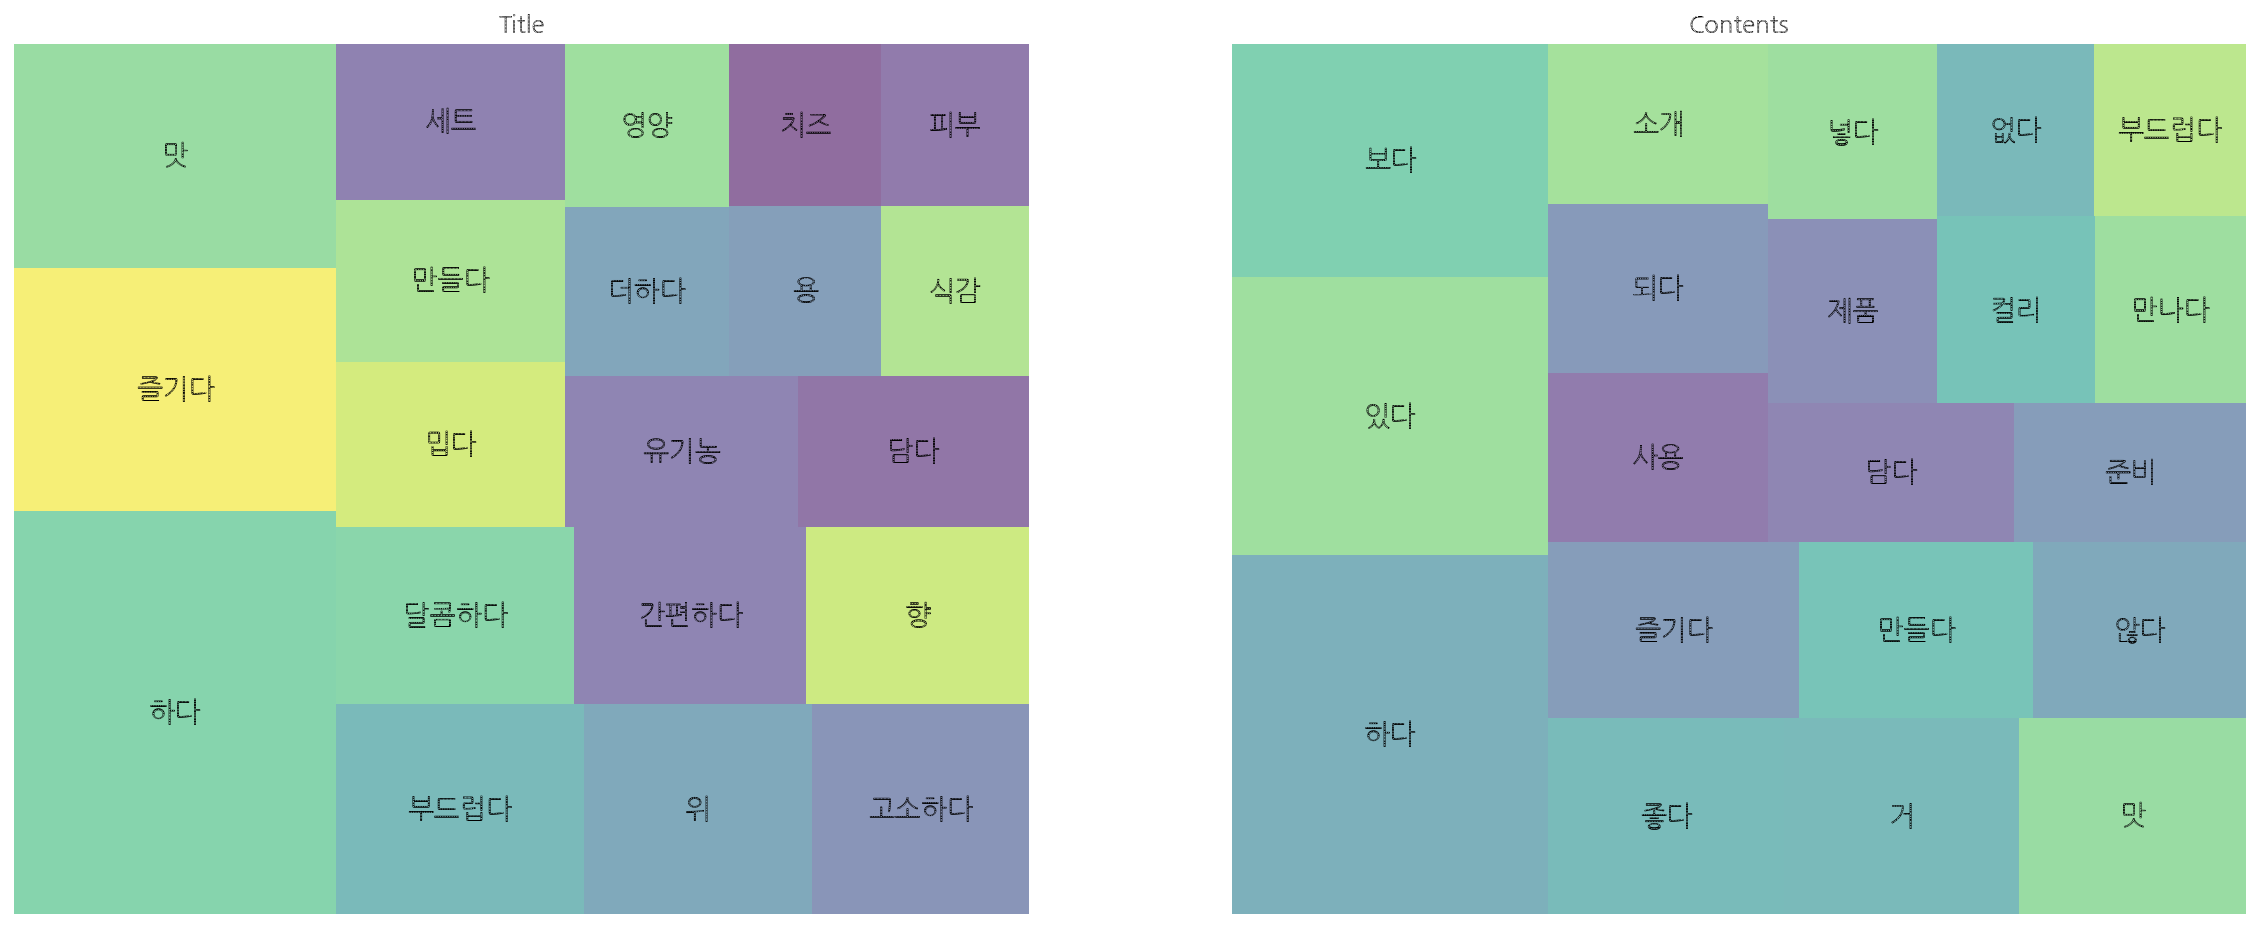

In [ ]:
# 시각화
import squarify
%config InlineBackend.figure_format='retina'

wc_top20 = title_wc[title_wc['rank'] <= 20]
wc_contents_top20 = contents_wc[contents_wc['rank'] <= 20]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('Title')
squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.6, ax=axes[0], text_kwargs={'fontsize':14})
axes[0].axis('off')

axes[1].set_title('Contents')
squarify.plot(sizes=wc_contents_top20['percent'], label=wc_contents_top20['word'], alpha=0.6, ax=axes[1], text_kwargs={'fontsize':14})
axes[1].axis('off')

plt.show()

### 형용사 토큰화

In [ ]:
# 불용어, 특수문자 제거 후 토큰화 하는 함수
def text_adj(text):
    
    txt = re.sub('[^가-힣a-z]', ' ', text)
    token = okt.pos(txt, stem=True)
    adj=[]
    for word in token:
      if word[1] in ['Adjective']:
        adj.append(word[0])
        
    return adj

In [ ]:
# title과 contents에 적용
title_adj = []
for i in range(len(titles)):
  title_adj.append(text_adj(titles[i]))

contents_adj = []
for i in range(len(contents)):
  contents_adj.append(text_adj(contents[i]))

In [ ]:
df['adj_title'] = title_adj
df['adj_contents'] = contents_adj
df.head()

,title,contents,label,stem_title,stem_contents,adj_title,adj_contents
0,합리적 가격으로 만나는 국내산 애호박 애호박,"어느 요리에든 어울리는, 만능 채소 일순위로 손꼽히는 애호박을 합리적인 가격으로 만...",1.0,"[합리, 가격, 만나다, 국내, 산, 애호박]","[요리, 어울리다, 만능, 채소, 위로, 손꼽다, 애호박, 합리, 가격, 만나다, ...",[],"[좋다, 좋다, 뛰어나다, 선명하다, 부드럽다, 신선하다, 있다, 풍부하다, 원하다]"
1,원하는 대로 섞어 만드는 하루치 건강 무농약 간편 샐러드,"짙은 녹색의 잎채소는 식이섬유부터 미네랄, 철분, 비타민, 엽산 등 각종 영양분이 ...",1.0,"[원하다, 대로, 섞다, 만들다, 하루, 치, 건강, 무, 농약, 간편, 샐러드]","[짙다, 녹색, 잎채소, 식이섬유, 미네랄, 철분, 비타민, 엽산, 각종, 영양분,...",[원하다],"[짙다, 풍부하다, 간편하다, 있다]"
3,무농약 콩으로 기른 장인의 나물 국내산 무농약 콩나물,"4대 째 두부 장인의 전통을 이어온 브랜드, 김구원선생의 콩나물을 소개할게요. 햇빛...",1.0,"[무, 농약, 콩, 기르다, 장인, 나물, 국내, 산, 콩나물]","[대다, 째다, 두부, 장인, 전통, 이다, 온, 브랜드, 김구, 선생, 콩나물, ...",[],"[중요하다, 안전하다, 필요하다, 손쉽다, 있다]"
4,청량하고 아삭한 채소 다다기오이,"마디마다 열매가 다닥다닥 열린다 하여 붙여진 이름, 다다기오이. 꼭지로 갈수록 점차...",1.0,"[청량하다, 삭, 채소, 다다, 오이]","[마디, 열매, 린다, 하다, 붙이다, 이름, 다다, 오이, 꼭지, 갈수록, 점차,...",[청량하다],"[뛰어나다, 있다, 우수하다, 다양하다, 좋다, 없다, 알뜰하다, 싱그럽다]"
5,"맛과 식감, 영양마저 뛰어난 참타리 버섯","'참타리버섯' 하면 조금 낯설게 느껴질 수 있겠지만, 우리에게 친숙한 느타리 버섯의...",1.0,"[맛, 식감, 영양, 뛰어나다, 차다, 타다, 버섯]","[차다, 타다, 버섯, 하다, 조금, 낯설다, 느껴지다, 있다, 친숙하다, 느타리,...",[뛰어나다],"[낯설다, 있다, 친숙하다, 없다, 아니다, 다양하다, 없다, 뛰어나다, 편안하다,..."


In [ ]:
word_count(df['adj_title']).head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
25,부드럽다,641,649,1.0,0.061128,0.061128,0.051461
3,고소하다,560,565,2.0,0.053217,0.114345,0.044958
16,달콤하다,521,524,3.0,0.049355,0.163700,0.041827
20,간편하다,507,508,4.0,0.047848,0.211548,0.040703
29,밉다,466,473,5.0,0.044551,0.256099,0.037412


In [ ]:
word_count(df['adj_contents']).head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
1,있다,9365,17107,1.0,0.154538,0.154538,0.751846
6,좋다,4898,6333,2.0,0.057210,0.211747,0.393224
15,없다,2868,3295,3.0,0.029766,0.241513,0.230250
3,부드럽다,2805,3051,4.0,0.027561,0.269074,0.225193
9,간편하다,2620,2776,5.0,0.025077,0.294152,0.210340


#### word cloud

In [ ]:
!pip install konlpy wordcloud

In [ ]:
from collections import Counter

# Counter 객체는 리스트요소의 값과 요소의 갯수를 카운트 하여 저장하고 있습니다.
# 카운터 객체는 .update 메소드로 계속 업데이트 가능합니다.
word_counts = Counter()

# 토큰화된 각 리뷰 리스트를 카운터 객체에 업데이트 합니다. 
df['adj_title'].apply(lambda x: word_counts.update(x))

# 가장 많이 존재하는 단어 순으로 10개를 나열합니다
word_counts.most_common(5)

[('부드럽다', 649), ('고소하다', 565), ('달콤하다', 524), ('간편하다', 508), ('밉다', 473)]

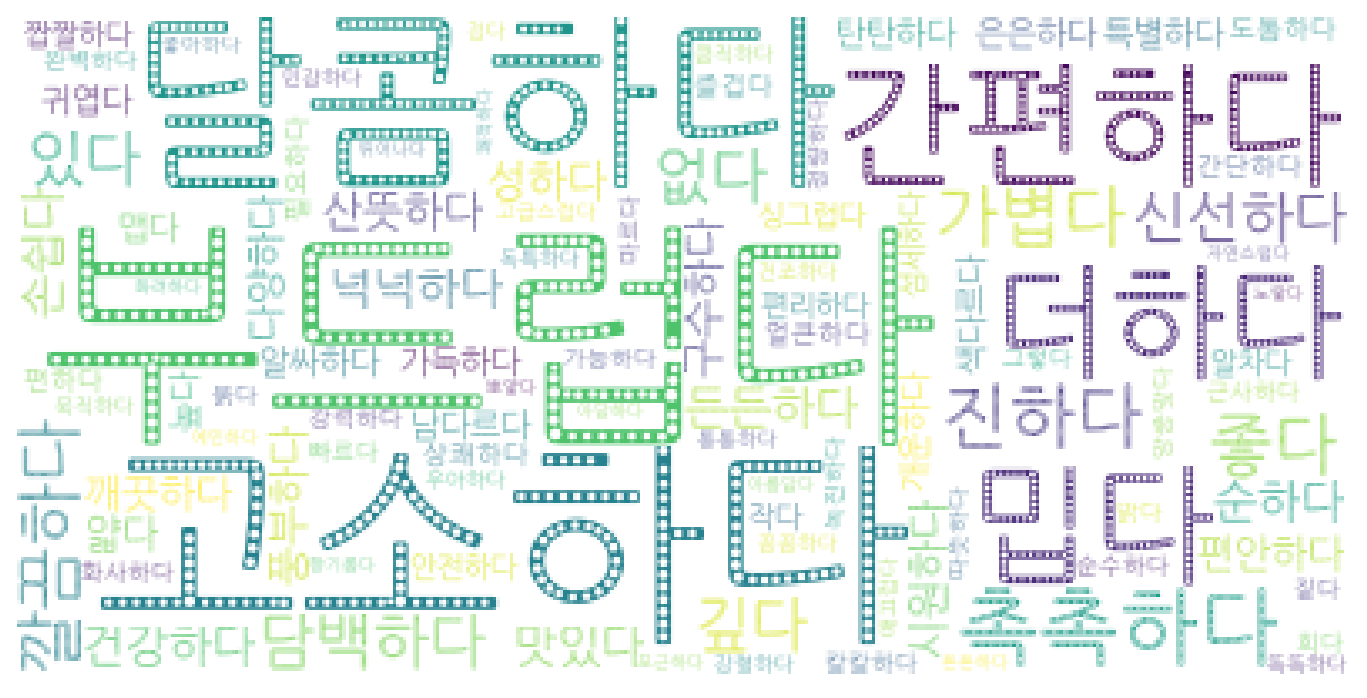

In [ ]:
from wordcloud import WordCloud
%config InlineBackend.figure_format='retina'

data = word_counts.most_common(100)

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
wc = WordCloud(font_path=path, relative_scaling=0.2, background_color='#FFFFFF').generate_from_frequencies(dict(data))

plt.figure(figsize=(12,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
contents_counts = Counter()

# 토큰화된 각 리뷰 리스트를 카운터 객체에 업데이트 합니다. 
df['adj_contents'].apply(lambda x: contents_counts.update(x))

# 가장 많이 존재하는 단어 순으로 10개를 나열합니다
contents_counts.most_common(5)

[('있다', 17107), ('좋다', 6333), ('없다', 3295), ('부드럽다', 3051), ('간편하다', 2776)]

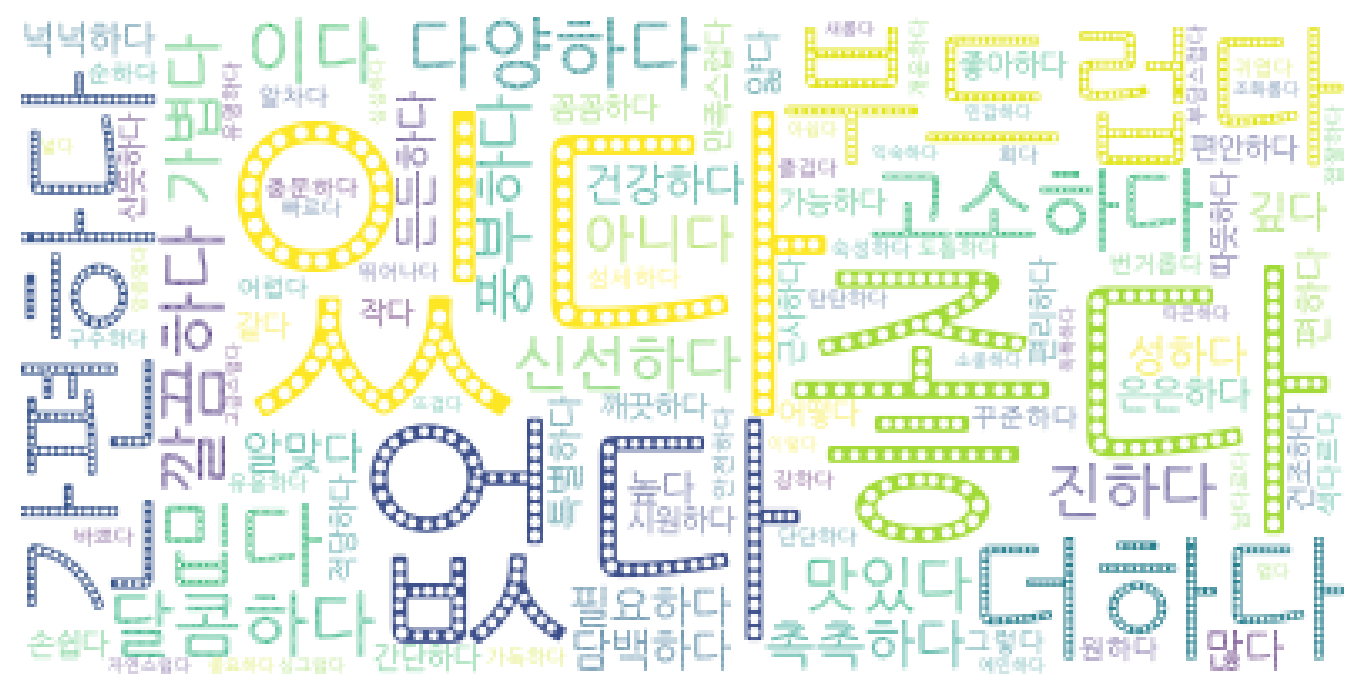

In [ ]:
data = contents_counts.most_common(100)

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
wc = WordCloud(font_path=path, relative_scaling=0.2, background_color='#FFFFFF').generate_from_frequencies(dict(data))

plt.figure(figsize=(12,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

- 제목 카피에는 '부드럽다, 고소하다, 간편하다, 달콤하다'와 같은 메뉴의 특징을 축약한 형용사가 주로 사용됨
- 컨텐츠 카피에는 '있다. 좋다. 없다. 더하다.' 와 같은 동사형 형용사가 주로 사용됨

## 길이 기준

Title 최대 길이 : 16
Title 평균 길이 : 7.353484264611432 



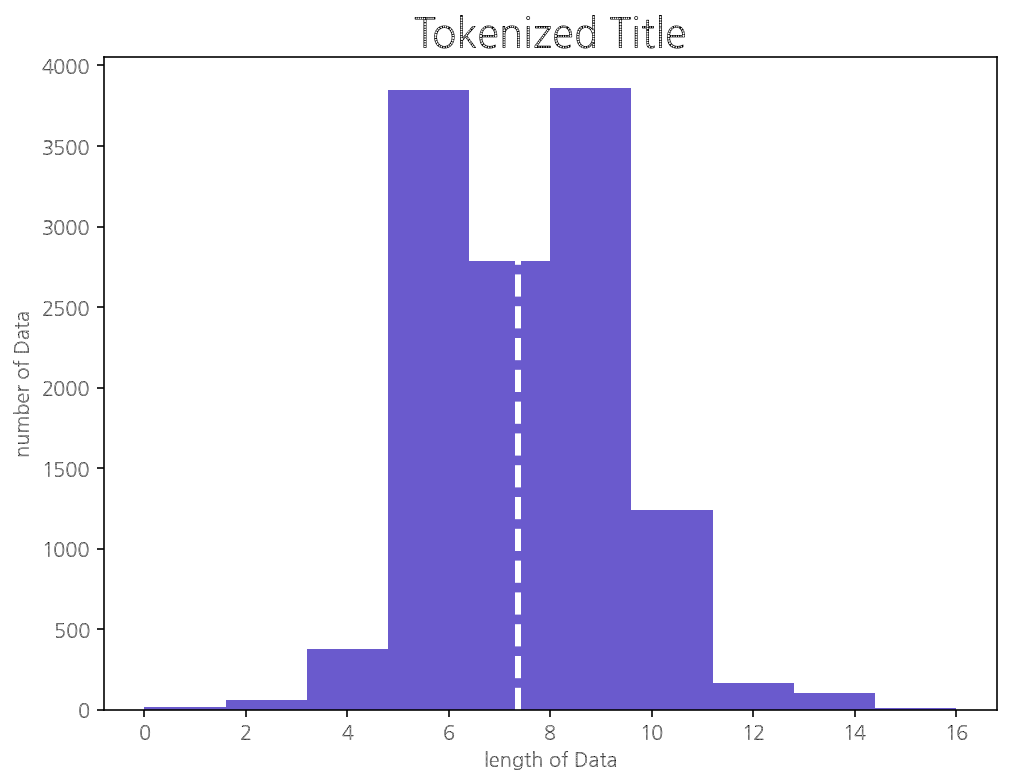

In [ ]:
max_text = max(len(l) for l in title_token)
mean_text = sum(map(len, title_token)) / len(title_token)
print('Title 최대 길이 : {}'.format(max_text)) 
print('Title 평균 길이 : {} \n'.format(mean_text)) 

plt.figure(figsize=(8,6))
plt.hist([len(s) for s in title_token], color='slateblue') 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.title('Tokenized Title', fontdict={'fontsize':20})
plt.axvline(x=mean_text, color='w', linestyle='--', linewidth=3)
plt.show()

Contents 최대 길이 : 125
Contents 평균 길이 : 54.37516056518947 



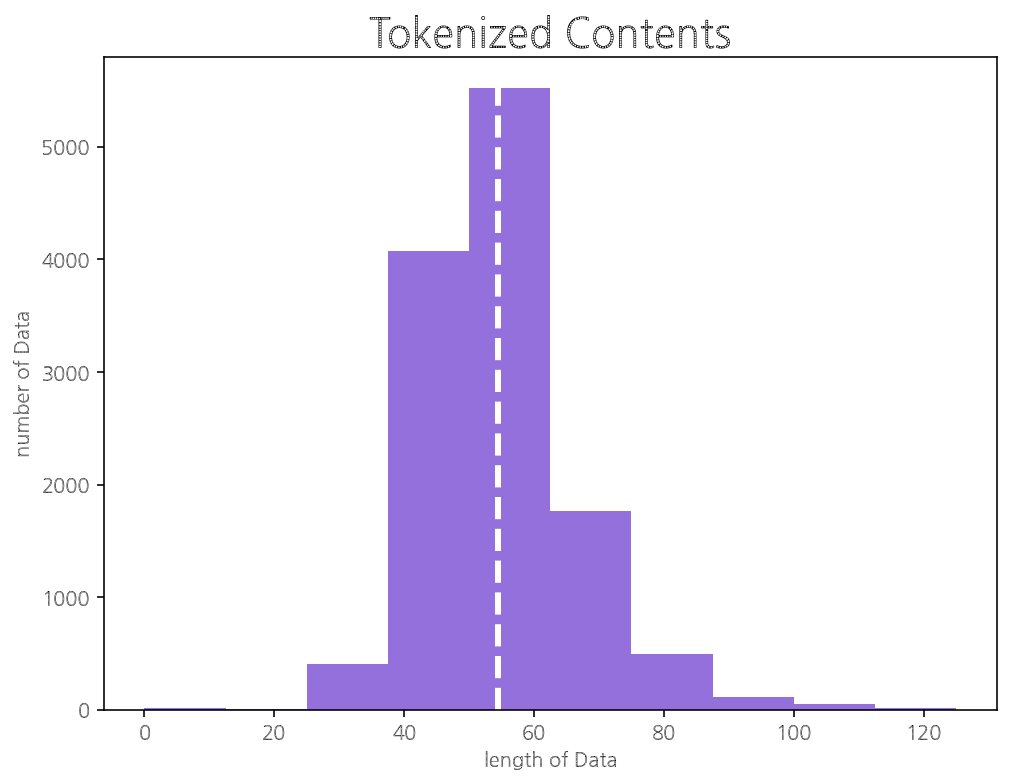

In [ ]:
max_text = max(len(l) for l in contents_token)
mean_text = sum(map(len, contents_token)) / len(contents_token)
print('Contents 최대 길이 : {}'.format(max_text)) 
print('Contents 평균 길이 : {} \n'.format(mean_text)) 

plt.figure(figsize=(8,6))
plt.hist([len(s) for s in contents_token], color='mediumpurple') 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.title('Tokenized Contents', fontdict={'fontsize':20})
plt.axvline(x=mean_text, color='w', linestyle='--', linewidth=3)
plt.show()

# 토큰화

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(title_token)
vocab_size = len(title_token)+1
vocab_size

12457

In [ ]:
sequences = list()

for line in title_token: 
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:6]

[[1513, 1919],
 [1513, 1919, 117],
 [1513, 1919, 117, 118],
 [1513, 1919, 117, 118, 29],
 [1513, 1919, 117, 118, 29, 1421],
 [1269, 3384]]

In [ ]:
index_to_word={}
for key, value in tokenizer.word_index.items(): 
    index_to_word[value] = key

In [ ]:
sequences = pad_sequences(sequences, maxlen=max_text, padding='pre')
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [ ]:
y = to_categorical(y, num_classes=vocab_size)

# 모델 생성

In [ ]:
!pip install pyyaml h5py

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# callback, earlysotpping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

## epochs=10, acc=0.4

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_text-1))
# y데이터를 분리하였으므로 이제 X데이터의 길이는 기존 데이터의 길이 - 1
model.add(LSTM(128))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X, y, batch_size=32, epochs=10, callbacks=[es, mc])

Epoch 1/10
2474/2474 [==============================] - 87s 34ms/step - loss: 7.7086 - accuracy: 0.0266
Epoch 2/10
2474/2474 [==============================] - 85s 34ms/step - loss: 6.8707 - accuracy: 0.0567
Epoch 3/10
2474/2474 [==============================] - 85s 34ms/step - loss: 6.2098 - accuracy: 0.1002
Epoch 4/10
2474/2474 [==============================] - 85s 34ms/step - loss: 5.6128 - accuracy: 0.1400
Epoch 5/10
2474/2474 [==============================] - 84s 34ms/step - loss: 5.0805 - accuracy: 0.1796
Epoch 6/10
2474/2474 [==============================] - 84s 34ms/step - loss: 4.6049 - accuracy: 0.2208
Epoch 7/10
2474/2474 [==============================] - 84s 34ms/step - loss: 4.1705 - accuracy: 0.2676
Epoch 8/10
2474/2474 [==============================] - 84s 34ms/step - loss: 3.7757 - accuracy: 0.3180
Epoch 9/10
2474/2474 [==============================] - 84s 34ms/step - loss: 3.4221 - accuracy: 0.3687
Epoch 10/10
2474/2474 [==============================] - 84s 34m

In [ ]:
def sentence_generation(model, t, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word # 처음 들어온 단어도 마지막에 같이 출력하기위해 저장
    sentence = ''
    for _ in range(n): # n번 반복
        encoded = t.texts_to_sequences([current_word])[0] # 현재 단어에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=23, padding='pre') # 데이터에 대한 패딩
        result = model.predict_classes(encoded, verbose=0)
    # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장.
        for word, index in t.word_index.items(): 
            if index == result: # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
                break # 해당 단어가 예측 단어이므로 break
        current_word = current_word + ' '  + word # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        sentence = sentence + ' ' + word # 예측 단어를 문장에 저장
    # for문이므로 이 행동을 다시 반복
    sentence = init_word + ' ' + sentence
    return sentence

In [ ]:
model.save('model_3rd_10.h5')

In [ ]:
print(sentence_generation(model, tokenizer, '샐러드', 6))
print(sentence_generation(model, tokenizer, '김치찌개', 6))
print(sentence_generation(model, tokenizer, '떡볶이', 6))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


샐러드  토핑 하다 즐기다 입 샐러드 누
김치찌개  하다 완성 되다 달콤하다 과일 잼
떡볶이  계절 든든하다 하다 그릇 갈비탕 버섯


In [ ]:
# 김치>매콤>감칠맛>주꾸미 순

## epochs=20, acc=0.74


In [ ]:
model = tf.keras.models.load_model('model_3rd_20.h5')
model.evaluate(X,y)

2474/2474 [==============================] - 23s 9ms/step - loss: 1.2092 - accuracy: 0.7463


[1.2091503143310547, 0.7463016510009766]

In [ ]:
print(sentence_generation(model, tokenizer, '샐러드', 6))
print(sentence_generation(model, tokenizer, '김치찌개', 6))
print(sentence_generation(model, tokenizer, '떡볶이', 6))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


샐러드  토핑 하다 좋다 쫄깃 어묵 조각
김치찌개  식감 그대로 담다 차 한잔 제주
떡볶이  소고기 더하다 매콤 반찬 제육 볶음


## epochs=50, acc=0.82

In [ ]:
history=model.fit(X, y, batch_size=32, epochs=30, callbacks=[es, mc])

Epoch 1/30
2474/2474 [==============================] - 66s 27ms/step - loss: 1.3544 - accuracy: 0.7119
Epoch 2/30
2474/2474 [==============================] - 66s 27ms/step - loss: 1.2727 - accuracy: 0.7258
Epoch 3/30
2474/2474 [==============================] - 65s 26ms/step - loss: 1.2080 - accuracy: 0.7376
Epoch 4/30
2474/2474 [==============================] - 66s 27ms/step - loss: 1.1515 - accuracy: 0.7470
Epoch 5/30
2474/2474 [==============================] - 66s 27ms/step - loss: 1.1014 - accuracy: 0.7562
Epoch 6/30
2474/2474 [==============================] - 66s 27ms/step - loss: 1.0533 - accuracy: 0.7633
Epoch 7/30
2474/2474 [==============================] - 67s 27ms/step - loss: 1.0145 - accuracy: 0.7705
Epoch 8/30
2474/2474 [==============================] - 67s 27ms/step - loss: 0.9761 - accuracy: 0.7763
Epoch 9/30
2474/2474 [==============================] - 67s 27ms/step - loss: 0.9421 - accuracy: 0.7824
Epoch 10/30
2474/2474 [==============================] - 67s 27m

In [ ]:
model = tf.keras.models.load_model('model_3rd_50.h5')
model.evaluate(X,y)

2474/2474 [==============================] - 23s 9ms/step - loss: 0.5547 - accuracy: 0.8431


[0.5546950697898865, 0.8430839776992798]

In [ ]:
print(sentence_generation(model, tokenizer, '샐러드', 6))
print(sentence_generation(model, tokenizer, '김치찌개', 6))
print(sentence_generation(model, tokenizer, '떡볶이', 6))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


샐러드  토핑 활용 하다 제격 비건 양념
김치찌개  깃 고소하다 감칠맛 김치 만두 배
떡볶이  이탈리아 향 밉다 스모크 고기 페스


In [ ]:
model.save('model_3rd_50.h5') 

## epochs=100, acc=0.82

In [ ]:
history=model.fit(X, y, batch_size=30, epochs=50, callbacks=[es, mc])

Epoch 1/50
2639/2639 [==============================] - 71s 27ms/step - loss: 0.6633 - accuracy: 0.8182
Epoch 2/50
2639/2639 [==============================] - 68s 26ms/step - loss: 0.6573 - accuracy: 0.8185
Epoch 3/50
2639/2639 [==============================] - 68s 26ms/step - loss: 0.6518 - accuracy: 0.8190
Epoch 4/50
2639/2639 [==============================] - 68s 26ms/step - loss: 0.6473 - accuracy: 0.8211
Epoch 5/50
2639/2639 [==============================] - 68s 26ms/step - loss: 0.6462 - accuracy: 0.8207
Epoch 6/50
2639/2639 [==============================] - 70s 27ms/step - loss: 0.6403 - accuracy: 0.8205
Epoch 7/50
2639/2639 [==============================] - 69s 26ms/step - loss: 0.6392 - accuracy: 0.8198
Epoch 8/50
2639/2639 [==============================] - 70s 26ms/step - loss: 0.6363 - accuracy: 0.8208
Epoch 9/50
2639/2639 [==============================] - 71s 27ms/step - loss: 0.6343 - accuracy: 0.8213
Epoch 10/50
2639/2639 [==============================] - 71s 27m

In [ ]:
model = tf.keras.models.load_model('model_3rd_100.h5')
model.evaluate(X,y)

2474/2474 [==============================] - 23s 9ms/step - loss: 0.4961 - accuracy: 0.8456


[0.49608492851257324, 0.8455979824066162]

In [ ]:
print(sentence_generation(model, tokenizer, '샐러드', 6))
print(sentence_generation(model, tokenizer, '김치찌개', 6))
print(sentence_generation(model, tokenizer, '떡볶이', 6))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


샐러드  토핑 활용 하다 제격 비건 양념
김치찌개  위 수제 껌 유기농 오미자 머
떡볶이  감칠맛 듬뿍 배다 갈비찜 액 티비


# 기본 모델 (불용어 등 제거 X)

In [ ]:
tokens = []

for i in range(len(titles)):
  tokens.append(okt.morphs(titles[i]))

In [ ]:
text = tokens
t = Tokenizer()
t.fit_on_texts(text)
vocab_size = len(text)+1
vocab_size

12457

In [ ]:
tokens[0]

['합리', '적', '가격', '으로', '만나는', '국내', '산', '애호박', '애호박']

In [ ]:
sequences = []

for line in text: 
    encoded = t.texts_to_sequences([line])[0] 
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

In [ ]:
max_len=max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 25


In [ ]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

## epochs=3, acc=0.2

In [ ]:
model_base = Sequential()
model_base.add(Embedding(vocab_size, 128, input_length=max_len-1))
# y데이터를 분리하였으므로 이제 X데이터의 길이는 기존 데이터의 길이 - 1
model_base.add(LSTM(128))
model_base.add(Dense(vocab_size, activation='softmax'))
model_base.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model_base.fit(X, y, batch_size=32, epochs=3)

Epoch 1/3
3655/3655 [==============================] - 106s 29ms/step - loss: 7.3215 - accuracy: 0.0507
Epoch 2/3
3655/3655 [==============================] - 104s 29ms/step - loss: 6.1010 - accuracy: 0.1317
Epoch 3/3
3655/3655 [==============================] - 103s 28ms/step - loss: 5.2852 - accuracy: 0.1928


In [ ]:
print(sentence_generation(model_base, t, '샐러드', 6))
print(sentence_generation(model_base, t, '김치찌개', 6))
print(sentence_generation(model_base, t, '떡볶이', 6))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


샐러드  와 함께 즐기는 유기농 귀리 유기농
김치찌개  에서 온 아이 를 위 한
떡볶이  의 풍 미를 담은 한 끼


## epochs=10, acc=0.62

In [ ]:
history=model_base.fit(X, y, batch_size=32, epochs=10)

In [ ]:
model_base=keras.models.load_model('model_base_10.h5')

In [ ]:
print(sentence_generation(model_base, t, '샐러드', 6))
print(sentence_generation(model_base, t, '김치찌개', 6))
print(sentence_generation(model_base, t, '떡볶이', 6))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


샐러드  에 구워 먹던 추억 의 맛
김치찌개  를 더해 더욱 시원한 알탕 사골
떡볶이  의 향 긋 함 을 더한


## epochs=20, acc=0.79

In [ ]:
history=model_base.fit(X, y, batch_size=32, epochs=10)

In [ ]:
model_base=keras.models.load_model('model_base_20.h5')

In [ ]:
print(sentence_generation(model_base, t, '샐러드', 6))
print(sentence_generation(model_base, t, '김치찌개', 6))
print(sentence_generation(model_base, t, '떡볶이', 6))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


샐러드  나 피자 토핑 으로 톡톡 냉동
김치찌개  를 더해 더 오래 쓰는 방법
떡볶이  의 풍 미를 두루 담은 간편


## epochs=50, acc=0.2

In [ ]:
history=model_base.fit(X, y, batch_size=32, epochs=30)

In [ ]:
model_base=keras.models.load_model('model_base_50.h5')

In [ ]:
print(sentence_generation(model_base, t, '샐러드', 6))
print(sentence_generation(model_base, t, '김치찌개', 6))
print(sentence_generation(model_base, t, '떡볶이', 6))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


샐러드  대신 가볍게 즐기는 한 끼 맛살
김치찌개  를 더해 오래 쓰는 방법 시
떡볶이  의 깊은 풍 미가 벨 지안


## epochs=100, acc=0.2

In [ ]:
history=model_base.fit(X, y, batch_size=32, epochs=50)

In [ ]:
model_base=keras.models.load_model('model_base_100.h5')

In [ ]:
print(sentence_generation(model_base, t, '샐러드', 6))
print(sentence_generation(model_base, t, '김치찌개', 6))
print(sentence_generation(model_base, t, '떡볶이', 6))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


샐러드  나 피자 토핑 으로 톡톡 냉동
김치찌개  를 사용 하는 무 항생제 1등
떡볶이  의 깊고 담백한 맛 의 조화


# +$a$) 어울리는 형용사 찾기

In [ ]:
df = df.drop(218).reset_index(drop=True)

In [ ]:
title_ls = []
for i in df['stem_title'] :
  try:
    title_ls.append(i[-1])
  except:
    title_ls.append('')

In [ ]:
df['title_ls'] = title_ls

In [ ]:
df_adj = df[['title_ls','adj_contents']]
df_adj = df_adj.groupby('title_ls').sum().reset_index()

In [ ]:
# 생략 없이 출력
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [ ]:
df_adj.loc[df_adj['title_ls'].str.contains('김치찌개')]

,title_ls,adj_contents
257,김치찌개,"[간편하다, 있다, 진하다, 깊다, 성하다, 더하다, 칼칼하다, 좋다, 있다, 따끈하다, 든든하다, 개운하다, 좋다, 정갈하다, 만족스럽다, 간편하다, 없다, 있다, 달콤하다, 부드럽다, 있다, 완벽하다, 짭짤하다, 고소하다, 같다, 특별하다, 진하다, 깊다, 있다, 큼직하다, 고소하다, 더하다, 따끈따끈하다, 든든하다, 있다, 맛있다, 쿰쿰하다, 있다, 개운하다, 깔끔하다, 뽀얗다, 넉넉하다, 더하다, 별다르다, 없다, 튼실하다, 색다르다, 얼큰하다, 진하다, 촉촉하다, 부드럽다, 좋다, 성하다, 시원하다, 있다, 있다, 있다, 어렵다, 이다, 깊다, 시큼하다]"


In [ ]:
df_adj.loc[df_adj['title_ls'].str.contains('샐러드')]

,title_ls,adj_contents
1396,샐러드,"[짙다, 풍부하다, 간편하다, 있다, 좋아하다, 많다, 그득하다, 있다, 없다, 이다, 고소하다, 넉넉하다, 싱그럽다, 부드럽다, 조화롭다, 성하다, 고소하다, 밉다, 더하다, 건강하다, 번거롭다, 어렵다, 다양하다, 간편하다, 따스하다, 건조하다, 작다, 좋다, 딱딱하다, 편안하다, 신선하다, 좋다, 경쾌하다, 싱그럽다, 별다르다, 가볍다, 간편하다, 좋다, 좋다, 좋다, 유명하다, 특별하다, 어떻다, 딱이다, 달콤하다, 조화롭다, 다양하다, 새롭다, 간편하다, 있다, 성하다, 있다, 충분하다, 있다, 느끼하다, 충분하다, 간편하다, 있다, 부드럽다, 더하다, 더하다, 고소하다, 있다, 신선하다, 담백하다, 꾸준하다, 남다르다, 밉다, 있다, 색다르다, 있다, 좋다, 밉다, 촉촉하다, 부드럽다, 더하다, 색다르다, 꾸준하다, 남다르다, 밉다, 있다, 고소하다, 가득하다, 더하다, 만족스럽다, 꾸준하다, 남다르다, 밉다, 있다, 통통하다, 싱그럽다, 성하다, 더하다, 탱탱하다, 덥다, 간편하다, 든든하다, 있다, 선명하다, 담백하다, ...]"


In [ ]:
df_adj.loc[df_adj['title_ls'].str.contains('떡볶이')]

,title_ls,adj_contents
599,떡볶이,"[충실하다, 많다, 있다, 많다, 유명하다, 있다, 깔끔하다, 좋아하다, 든든하다, 이다, 있다, 깊다, 근사하다, 있다, 더하다, 성하다, 깔끔하다, 딱이다, 다양하다, 좋다, 고소하다, 풍부하다, 있다, 같다, 있다, 있다, 동일하다, 얇다, 칼칼하다, 맵다, 맵다, 있다, 더하다, 있다, 같다, 간편하다, 있다, 덥다, 달콤하다, 말랑하다, 편리하다, 있다, 간편하다, 독특하다, 구수하다, 좋아하다, 달콤하다, 더하다, 새롭다, 넉넉하다, 좋다, 밉다, 어렵다, 간단하다, 있다, 적절하다, 간편하다, 가득하다, 즐겁다, 달콤하다, 더하다, 아기자기하다, 특별하다, 간편하다, 새롭다, 유명하다, 맛있다, 없다, 없다, 없다, 달콤하다, 맛있다, 맵다, 없다, 이다, 있다, 깔끔하다, 알차다, 넉넉하다, 다양하다, 있다, 달콤하다, 이다, 더하다, 맛있다, 좋다, 별다르다, 없다, 간편하다, 새롭다, 편하다, 있다, 있다, 있다, 손쉽다, 있다, 이다, 아니다, 조용하다, 있다, ...]"


# +$a$) 컨텐츠 카피로 베스트셀러 상품 예측

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.0    0.961542
1.0    0.038458
Name: label, dtype: float64


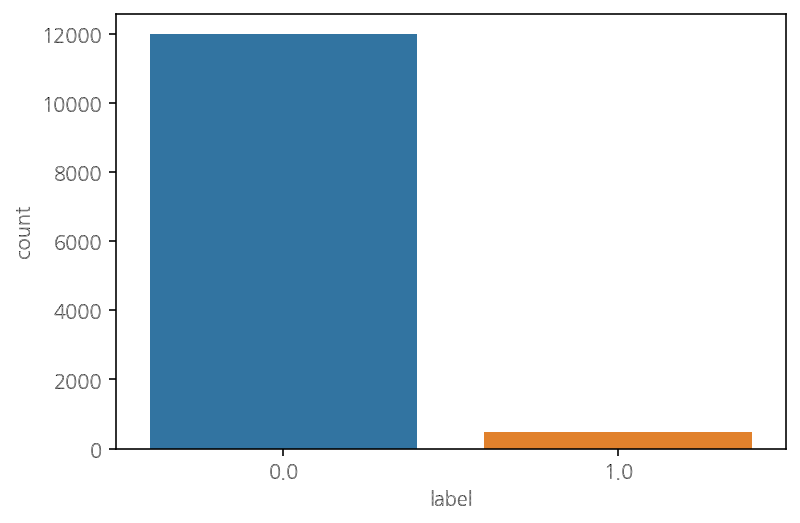

In [ ]:
#비율확인
import seaborn as sns

sns.countplot(df['label'])
plt.xlabel('label')
print(df['label'].value_counts(normalize=True))

In [ ]:
# 타겟값 지정
X = df['stem_contents']
Y = df['label']

# 데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True, stratify=Y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9964,), (9964,), (2491,), (2491,))

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 16963
등장 빈도가 2번 이하인 희귀 단어의 수: 7310
단어 집합에서 희귀 단어의 비율: 43.093792371632375
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7504032719474067


In [ ]:
# 전체 단어 개수 중 빈도수 3이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 9654


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

9948
9948


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 124
리뷰의 평균 길이 : 53.51166063530358


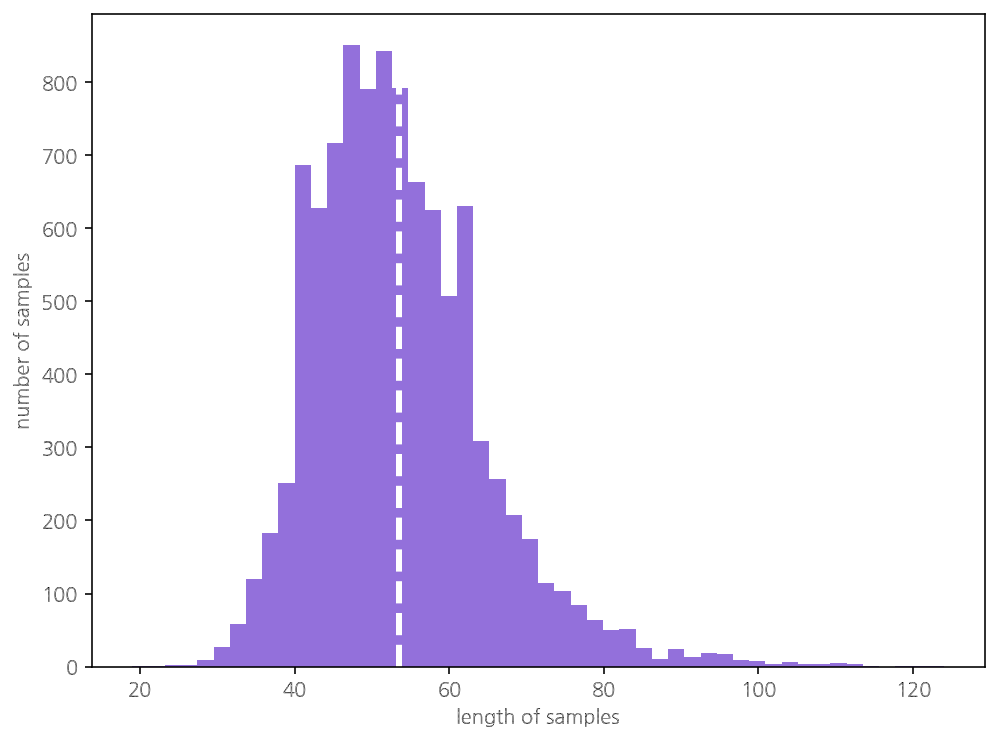

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.figure(figsize=(8,6))
plt.hist([len(s) for s in X_train], bins=50, color='mediumpurple')
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.axvline(x=sum(map(len, X_train))/len(X_train), color='w', linestyle='--', linewidth=3)
plt.show()

In [ ]:
X_train = pad_sequences(X_train, maxlen = 80)
X_test = pad_sequences(X_test, maxlen = 80)

In [ ]:
model_pred = Sequential([
  Embedding(vocab_size, 128),
  LSTM(128),
  Dense(1, activation='sigmoid')
])

model_pred.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

In [ ]:
model_pred.fit(X_train,y_train,batch_size=64,epochs=10,
          validation_split=0.2,callbacks=[es, mc])

Epoch 1/10
125/125 [==============================] - 7s 36ms/step - loss: 0.2009 - accuracy: 0.9563 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1578 - val_accuracy: 0.9628 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 4s 31ms/step - loss: 0.1544 - accuracy: 0.9612 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1604 - val_accuracy: 0.9628 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 4s 31ms/step - loss: 0.1106 - accuracy: 0.9644 - precision: 0.6857 - recall: 0.1553 - val_loss: 0.1698 - val_accuracy: 0.9603 - val_precision: 0.1429 - val_recall: 0.0135
Epoch 4/10
125/125 [==============================] - 4s 31ms/step - loss: 0.0713 - accuracy: 0.9769 - precision: 0.8238 - recall: 0.5146 - val_loss: 0.2113 - val_accuracy: 0.9618 - val_precision: 0.2500 - val_recall: 0.0135
Epoch 5/10
125/125 [==============================] - 4s 31ms/step -

In [ ]:
model_pred.evaluate(X_test, y_test)

78/78 [==============================] - 1s 7ms/step - loss: 0.2008 - accuracy: 0.9566 - precision: 0.2500 - recall: 0.0625


[0.20079612731933594, 0.9566439390182495, 0.25, 0.0625]

In [ ]:
def predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = 80) # 패딩
  score = float(model_pred.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 Best seller 입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 Best seller가 아닙니다.\n".format((1 - score) * 100))

In [ ]:
df.iloc[500]

title             간편하게 즐기는 샐러드용 채소  그린샐러드 파프리카&적채                                                                                                                                                                                                                                                                               
contents         그린샐러드 파프리카&적채로 신선한 샐러드용 채소를 즐겨 보세요. 프릴라이즈(양상추), 로메인, 적근대, 라디치오를 먹기 좋은 크기로 썰어 담고, 파프리카와 적채를 채썰어 토핑했어요. 아삭하게 씹히는 프릴라이즈와 경쾌한 식감의 파프리카를 비롯해 다채로운 채소들이 만나 더욱 싱그러운 맛을 전한답니다. 별다른 손질 없이 가볍게 씻어 주기만 하면 되니 소스나 드레싱을 곁들여 샐러드, 샌드위치 등에 간편하게 활용하기 좋을 거예요. 한 번에 즐기기 좋은 양과 두세 번에 나누어 먹기 좋은 양, 두 가지 용량으로 준비했으니 필요에 맞게 선택해 보세요.
label            0                                                                                                                                                                                                                                                                                                              
stem_title       [간편하다, 즐기다, 샐러드, 용, 

In [ ]:
predict(df.iloc[500].contents)

99.26% 확률로 Best seller가 아닙니다.



In [ ]:
df.iloc[127]

title             든든하고 푸짐한 한 그릇  갈비탕                                                                                                                                                                                                                                                          
contents         따뜻하게 속을 데우는 요리로 갈비탕을 빼놓으면 서운해요. 뼈에 붙은 갈비를 살살 발라 국물과 함께 먹으면 몸과 마음이 모두 든든해지죠. 갈비탕으로 소문난 브랜드인 강남면옥 또한 푸짐한 갈비탕을 들고 컬리를 찾았습니다. 살이 실하게 붙은 호주산 소갈비를 골라 깨끗하게 손질하고, 삶은 후 오래 뜸을 들여 육질이 부드러워요. 갈비 삶은 물로 육수를 만들어 국물맛 또한 깊지요. 잘 데운 후 밥과 함께 뜨끈한 한 상을 차려보세요. 기호에 따라 후추, 당면 등을 더해서 드셔도 좋습니다. 
label            1                                                                                                                                                                                                                                                                            
stem_title       [든든하다, 푸다, 짐, 하다, 그릇, 갈비탕]                                                                                                

In [ ]:
predict(df.iloc[127].contents)

86.78% 확률로 Best seller 입니다.



In [ ]:
new_sentence=sentence_generation(model, tokenizer, '갈비탕', 54)
print(new_sentence)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


갈비탕  따끈하다 식기 와인 갈비 영양소 색 마음 새 알맞다 크리미 일상 컬리 고요 자극 울다 알맞다 소개 맛있다 소개 편하다 성하다 분해 더불다 알맞다 여러 갈다 선택 부위 튀김 컬리 국내 기분 기와 쿠션 소개 국내 함 모양 본연 적다 식 그대로 추억 엑스트라 액 안심 담기다 고소하다 고소하다 본연 갈다 지방 높다 우유


In [ ]:
predict(new_sentence)

76.02% 확률로 Best seller가 아닙니다.



# 7. 개선점
1. 컨텐츠 카피 데이터 입력 시 램 용량이 초과 되어 제대로 활용할 수 없었던 점

  👉🏻 활용방안 찾기

2. 베스트셀러 데이터가 너무 적은 불균형한 데이터로 수집한 점

  👉🏻 더 많은 데이터 수집

3. 모델 출력물이 자연스럽지 못한 점

  👉🏻 불용어나 품사에 있어 적정한 변형점을 찾고, 모델 성능을 높일 수 있는 방안에 대한 고민